# COGS 118B - Team Real Moon Landers


# Names

- Sebastian Modafferi
- Chirag Amatya
- Michael Chu

# Abstract 

The goal of this project is to develop a reinforcement learning agent capable of controlling a cheetah in the HalfCheetah environment provided by Gymnasium. This environment simulates a cheetah running in a 2d environment where the agent controls the torque applied to hinge joints. The RL agent will use the 16-dimensional state space, consisting of geometric descriptions of the current cheetah and angular velocities of different limbs. A reward-based feedback system will guide the agent, encouraging fast runs while punishing unnecessary limb movement. The RL agent will process the data to learn an optimal policy for controlling the cheetah through iterative training. Success will be measured using total reward per episode.

# Background

Reinforcement learning (RL) has become a prominent approach for solving complex decision-making tasks, particularly in environments requiring continuous control and sequential decision-making. The Half Cheetah task, provided by the Gymnasium framework, serves as an effective benchmark for evaluating RL algorithms. This task involves controlling a cheetah as it runs via the torque applied to different joints in the body. Given the large, continuous state and action space of the environment, traditional dynamic programming methods are infeasible as they require complete knowledge of the environment's state transitions <a name="suttonnote"></a>[1]. In an effort to explore performances from different models on this task, we have selected three different approaches that we would like to use.

 - Twin-Delayed DDPG's (TD3) offer a similar technical approach to Deep Q Learning (DQN). However, they excel past DQN's in large continuous spaces. We decided to employ this approach because a DQN is simple unfeasible for the observation and action spaces we are dealing with. We felt that a TD3 model would somewhat express a more baseline approach that we could use to compare against more complex models. <a name="TD3"></a>[2].
 - Proximal Policy optimization is a more complex spin on simple Monte Carlo approaches. It utilizes multiple gradients to optimize the policy function via minibatch updates. It has shown to be more effective than single policy optimization appraoches. We chose to employe it due to its increased performance despite slightly more computational complexity. <a name="PPO"></a>[3].
 - Genetic Algorithms are an exciting branch of reinforcement learning. THey offer the ability to explore complex action spaces and combine previously found solutions into more powerful models. Using genetic algorithms to train a neural network is not a novel task, however we elected to manually build the model training code by ourselves for increased customizability and hyperparameter optimization. <a name="GNN"></a>[4].


# Problem Statement

The problem we are solving is the [Half Cheetah](https://gymnasium.farama.org/environments/mujoco/half_cheetah/) provided by the `gymnasium` python package. The task is to manuever the cheetah such that it moves as fast as possible in the positive x direction while optimizing for reduced required movement. The cheetah is a "2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws)". This includes the head, the body, and four limbs. The task begins with the cheetah in an initial position that is randomly sampled along a uniform distribution, and an initial velocity that is randomly sampled along a normal distribution. The cheetah must then correct for this randomness and begin the task of galloping using the four limbs through inputs of angular torques. The total reward breakdown is listed below, as described on [the docs](https://gymnasium.farama.org/environments/mujoco/half_cheetah/).

The total reward is:  
**reward = forward_reward - ctrl_cost**.

- **forward_reward**: A reward for moving forward, this reward would be positive if the Half Cheetah moves forward (in the positive *x* direction / in the right direction).  
  $ w_{\text{forward}} \times \frac{dx}{dt} $, where $ dx $ is the displacement of the "tip" ($ x_{\text{after-action}} - x_{\text{before-action}} $),  
  $ dt $ is the time between actions, which depends on the `frame_skip` parameter (default is 5), and `frametime` which is 0.01 -  
  so the default is:  

  $$ dt = 5 \times 0.01 = 0.05 $$

  $ w_{\text{forward}} $ is the `forward_reward_weight` (default is 1).

- **ctrl_cost**: A negative reward to penalize the Half Cheetah for taking actions that are too large.  
  $ w_{\text{control}} \times \| \text{action} \|_2^2 $, where $ w_{\text{control}} $ is `ctrl_cost_weight` (default is 0.1).



# Data


For the HalfCheetah environment from Gymnasium, the data consists of simulated episodes of a 2D cheetah robot learning to run. The dataset is dynamically generated using the environment and represents the cheetah's state transitions as it interacts with the environment. Due to the nature of training reinforcement learning models, no dataset will be collected or manufactured from the simulation. Instead, the agents will learn via exploration and repeated simulations.

Source: Gymnasium HalfCheetah environment (`gymnasium.make("HalfCheetah-v5")`).
Size: The exact number of episodes required for training will vary by model, however we are looking to benchmark progress after 10,000 episodes of training. This benchmark will then compute the average performance over 100 simulations.
Observation Space:

__Observation Space__: 
A 17-dimensional state vector (by default):

        z-coordinate of the front tip (position)
        Angle of the front tip (rad)
        Angle of the back thigh (rad)
        Angle of the back shin (rad)
        Angle of the back foot (rad)
        Angle of the front thigh (rad)
        Angle of the front shin (rad)
        Angle of the front foot (rad)
        Velocity of the x-coordinate of front tip (m/s)
        Velocity of the z-coordinate of front tip (m/s)
        Angular velocity of the front tip (rad/s)
        Angular velocity of the back thigh (rad/s)
        Angular velocity of the back shin (rad/s)
        Angular velocity of the back foot (rad/s)
        Angular velocity of the front thigh (rad/s)
        Angular velocity of the front shin (rad/s)
        Angular velocity of the front foot (rad/s)


The observation values are floating-point numbers (float64).
Note: The x-coordinate is excluded by default, but can be included by setting exclude_current_positions_from_observation=False, which would make it an 18-dimensional vector.


__Action Space__:

A 6-dimensional continuous action vector with each value in range [-1, 1]:

        Torque applied on the back thigh rotor
        Torque applied on the back shin rotor
        Torque applied on the back foot rotor
        Torque applied on the front thigh rotor
        Torque applied on the front shin rotor
        Torque applied on the front foot rotor

The action values are float32.


__Reward Function__:

        Total reward = forward_reward - ctrl_cost
        forward_reward: Positive reward for moving forward (in the x-direction)
        ctrl_cost: Negative reward to penalize large control actions (torques)
        Parameters:

        forward_reward_weight (default: 1.0)
        ctrl_cost_weight (default: 0.1)


__Starting State__:

        Initial position and velocity states are drawn from a random distribution
        Controlled by reset_noise_scale parameter (default: 0.1)


__Episode End__:

        The environment never terminates naturally
        Episodes are truncated after 1000 timesteps by default

# Proposed Solutions

### Twin Delayed DDPG
(Michael) TD3 is a model-free, off-policy actor-critic algorithm designed for continuous action spaces, improving upon DDPG by addressing overestimation bias and training instability. TD3 enhances DDPG with three key improvements.

- Clipped Double Q-learning, which uses two critic networks $ Q*{\theta_1}(s, a) $ and $ Q*{\theta_2}(s, a) $, and takes the minimum to reduce overestimation bias.

- Delayed Policy Updates, where the actor is updated less frequently than the critics to improve stability.

- Target Policy Smoothing, where clipped noise is added to target actions to prevent the policy from exploiting sharp Q-function peaks.

The critic target is computed as:

$y = r + \gamma \cdot \min_{i=1,2} Q_{\theta_i'}\left(s', \pi_{\phi'}(s') + \epsilon \right), \quad \epsilon \sim \text{clip}\left(\mathcal{N}(0, \sigma), -c, c\right)$

where $ \pi\_{\phi'} $ is the target actor network, $ \theta_i' $ are the target critic networks, $ \gamma $ is the discount factor, and $ \epsilon $ is the clipped noise. This approach improves learning stability and sample efficiency in high-dimensional, continuous action environments like HalfCheetah.

### Proximal Policy Optimization
(Chirag) Proximal Policy Optimization (PPO) is a reinforcement learning algorithm that iteratively updates an agent’s policy based on interactions with the environment while ensuring that the updates remain within a controlled range. By collecting trajectories and applying policy gradients, PPO strikes a balance between exploration and exploitation, enabling the agent to learn effectively without taking overly large steps that could destabilize learning.

PPO employs a surrogate objective function with a clipping mechanism to limit drastic policy changes. The core idea involves computing a probability ratio,
$$
rt(\theta) = \frac{\pi\theta(a_t \mid st)}{\pi{\theta_{\text{old}}}(a_t \mid s_t)},
$$
which is then multiplied by an advantage estimate $\hat{A}_t$. The objective maximizes
$$
\min\Big(r_t(\theta)\hat{A}_t,; \text{clip}(r_t(\theta),; 1-\epsilon,; 1+\epsilon)\hat{A}_t\Big),
$$
thus constraining the updates. Additional elements of PPO include minimizing a value function loss and optionally adding an entropy bonus to encourage exploration.


### Genetic Neural Network
(Sebastian) The third agent will be a genetically-trained neural network (inspiration<a name="gtnn"></a>[<sup>[5]</sup>](#gtnn)). The exact nueral network structure will remain consisent across generations. However the weights, biases, and connections will be trained through mating and mutating the highest performing members of the population. The exact neuron and layer counts will be hyperparameter optimized for. This will be an effective solution because neural networks are well suited for agent-based tasks, specifically where the agent has a discrete set of actions to take in an environment. Through many generations of breeding and mutating the highest performing genomes, the agent will increasingly perform better and better. Genome-based learning is essential for this implementation due to the lack of a dataset. Using a reinforecement-learning approach will remove the need for us to manufacture a dataset from the environment -- instead allowing the agent to explore the action-observation space relationship.

The genetic neural network training was very computationally expensive, and therefore could not be fully examined properly given our available resources. Training undertook a period of 5 hours, where an initial population of 250 was trained for 500 generations. The population was ranked by their performance on only one instance of the simulation, and was selected for reproducing using a weighted probability distribution where 
$$\text{scores} = \text{scores} - \text{minimum score}$$
$$P(\text{Individual}) = \frac{\text{Individual Score}}{\sum{\text{Population Scores}}}$$
The initial adjustment is required to manage the negative scores that appear in the beginning of training. Due to each member of the population only being examined for score once, the total information provided on each individual is under an ideal amount, however again we were computationally limited. Once the breeding distribution was generated, it was randomly sampled for two parents which were then bred and the child added to the new population. The population size remained constant at 250 for each generation. Additionally, the highest 1% of performing individuals were copied from the previous generation, a process known as _elitism_. This forced the model to not discard current best solutions, and provided these overperformers more time to populate the gene pool with their excellence before being surpassed. This proccess does reduce genetic variability but ensures a stable training.

During breeding, the created network was generated using neuron-wise selection from each of the two parents. There was a 50% chance to select the neuron from parent A, and a 50% chance to select from parent B. The network structure did not change between individuals, as the implementation for this specific process was too complex for my understanding. I could have elected to implement the NEAT algorithm, which does handle a more complex breeding process, but at my own detriment, I chose to hand-write the entire algorithm using numpy and base python. This definitely negatiely impacted the training time and therefore available findings.

The mutation process had a variable mutation rate over generations, where it decreased from an initial 30% mutation rate to a final 5% mutation rate over the course of roughly 75 generations. This helped to prioritize genetic exploration initially, allowing the model to find enough niche's that could be optimized for in the later generations of training. The process of mutation included a 49.5% chance to multiply the neuron's values by a corresponding vector sampled normally with a mean of 1 and standard deviation of 0.2. This multiplication vector had a 50% chance to be negative or positive for each index. There was additionally a 49.5% chance to add the neuron's vector by a corresponding vector sampled normally with a mean of 0 and standard deviation of 0.1. Because these operations have a chance to disable a neuron (set it's values to 0), there is a 1% chance to 'reset' the neuron, which normally samples values along a range of [-3, 3]. The decaying mutation rate is described below. Once the value is less than 5%, the minimum mutation rate of 5% stays constant.
$$P(\text{mutation}) = 30\% \times e^{-0.01 \times \text{generation number}}$$

Each genome consists of the neural networks weights and biases. The final neural network included 3 hidden layers each of size 512. For the exact implemenation, reference `seb_gnn.ipynb`.

# Evaluation Metrics

In this implementation, we use two main evaluation metrics to assess the performance of the TD3 agent on the HalfCheetah-v5 environment:

### 1. Reward per Episode Graph

- **Purpose:**  
  This graph tracks the cumulative reward obtained at the end of each episode during training. It serves as a quantitative measure of the agent's learning progress.

- **How It Works:**  
  For each episode, we calculate the total reward:
  $
  R_i = \sum_{t=0}^{T_i} r_t
  $
  where:
  - $ R_i $ is the total reward for the $i^\text{th}$ episode,
  - $ r_t $ is the reward at timestep $ t $,
  - $ T_i $ is the number of timesteps in episode $ i $.

- **Interpretation:**  
  - **Increasing Trend:** Indicates that the agent is learning and improving over time.
  - **Plateaus or High Variance:** May suggest issues like convergence challenges or instability in learning.

- **Visualization:**  
  The reward per episode graph is plotted after training to provide feedback on the agent's performance.

### 2. Evaluation Video

- **Purpose:**  
  The evaluation video offers a qualitative assessment by visually demonstrating how the trained agent behaves in the environment. It allows us to observe the agent's control, stability, and overall interaction with the HalfCheetah-v5 environment.

- **How It Works:**  
  - The environment is run with the trained agent (with noise disabled for evaluation) to capture a sequence of frames.
  - These frames are compiled into a video (using the `imageio` library) to visually inspect the agent’s performance.

- **Interpretation:**  
  The video helps confirm that the policy learned by the agent is effective and that the actions taken result in coherent and expected behavior in the simulated environment.




# Results

__For code regarding specific implementations, check the repo folders assigned to each model__.

### Twin Delayed DDPG (TD3) Results

In [ ]:
from IPython.display import Video, Image

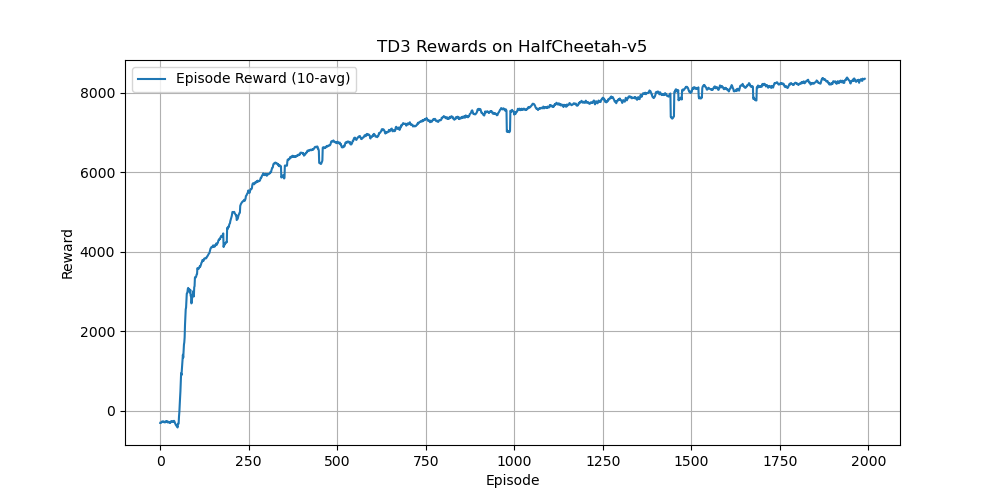

In [8]:
Image("./td3/td3_rewards.png", embed=True)

In [4]:
Video("./td3/td3_eval.mp4", embed=True)


##### TD3 Results Discussion
The TD3 algorithm proves to be effective in solving the HalfCheetah-v5 MuJoCo environment. We observed a clear upward trajectory in episodic rewards as training progressed, showing TD3's stability and performance in continuous control tasks.

The figure below shows the 10-episode moving average of TD3's episodic rewards over 1,000 episodes. Initially, rewards increase rapidly, indicating quick policy improvement. Around episode 100, the agent consistently achieves over 3000 reward. This growth continues, plateauing near 8000 reward by episode 1900, indicating policy convergence. Longer training may have shown even higher rewards. Small occasional reward drops likely are due to stochastic transitions or slight instability in critic updates, but the overall trend is strongly positive.


### Proximal Policy Optimization (PPO) Results

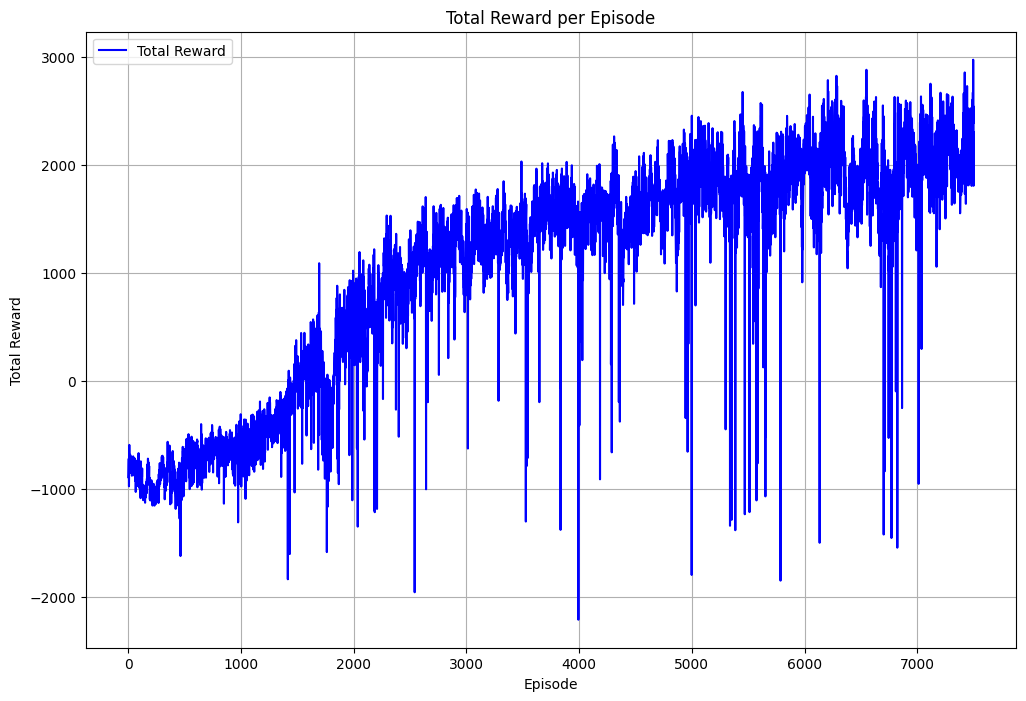

      episode  total_reward   value_loss   policy_loss
0           1   -894.414425  5430.958496  4.386902e-08
1           2   -862.174673  5116.721191  7.390976e-09
2           3   -771.571901  4333.743652  2.670288e-08
3           4   -767.055315  4222.027832 -1.621246e-08
4           5   -723.241908  3620.252686  1.239777e-08
...       ...           ...          ...           ...
7495     7496   2382.531366  3400.756348  8.583068e-09
7496     7497   2540.717846  5979.435547 -5.245209e-08
7497     7498   1804.141057  4680.467773  1.373291e-07
7498     7499   2194.611156  3283.687012  4.005432e-08
7499     7500   2302.039166  3848.408203 -1.535416e-07

[7500 rows x 4 columns]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the training log (a list of dictionaries) into a DataFrame
df_log = pd.DataFrame(training_log)

# Create a plot for Total Reward per Episode
plt.figure(figsize=(12, 8))
plt.plot(df_log['episode'], df_log['total_reward'], label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()
print(df_log)


In [3]:
Video('./vid/PPO_agent.mp4')

#### PPO Results Discussion
The graph shows that total rewards start off negative but steadily improve, suggesting the agent is learning an effective running strategy in the HalfCheetah environment. 
PPO’s clipped objective helps keep updates stable while still allowing enough exploration as shown by how the graph wil quickly recover after steep drops, 
which explains the general upward trend despite occasional dips.

### Genetic Neural Network (GNN) Results

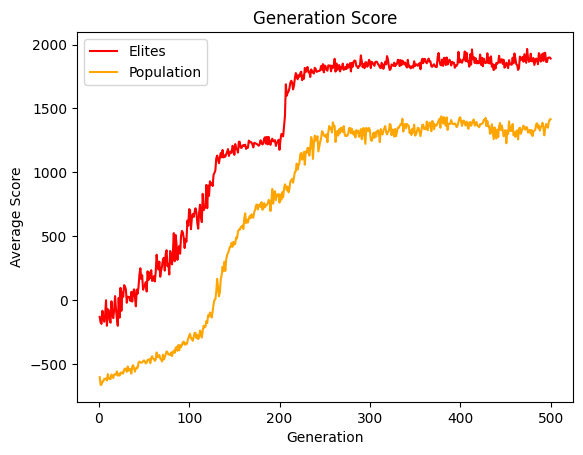

In [ ]:
env = gym.make('HalfCheetah-v5')

population = Population(env, pop_size=250)

population.iterate_generations(500)

In [ ]:
Video('./gnn/gnn_simple/HalfCheetah-gen400-episode-0.mp4', embed=True)

#### GNN results discussion

The training curve shows clear evidence of learning, and seemed to reach an equilibrium at around 220 generations, where the population and elites did not get much better. This is likely due to the small population size converging onto one optimal solution, removing variability and in turn effectively ending the training process of the model. The final performance being around 2000 total score per individual is very mediocre. I believe the under performance of this algorithm is due to the very small population size, and low neural network size. These limitations are the result of limited computational resources being available for extended durations.

# Discussion

### Interpreting the results

The first, and most important destinction, is that TD3 learning out performed our other two models. We believe that
 - __In comparison to GNN__: TD3's critic evaluation process is very efficient with this task, as it is able to link specific actions with specific rewards. Genetic learning only links an individual's episode performance to their overall rank. This allows the TD3 learning model to recieve more context from each simulation. 
 - __In comparison to PPO__: TD3 is off-policy, meaning it can reuse past experiences effectively, which is especially beneficial in environments with a continuous action space like HalfCheetah. Additionally, its deterministic policy, combined with twin critics and delayed policy updates, helps reduce overestimation bias and stabilizes learning. This enables TD3 to fine-tune its control strategies more effectively than PPO, which is on-policy and generally less sample efficient in such settings.


### Limitations

 - __GNN__: The main limitation with our GNN approach was the computational complexity. Storing, breeding, mutating, and simulating hundreds of genomes turned out to be very computationally expensive. This resulted in a model that was not truly able to excel as much as prior research has shown. We were unable to increase population size or total neuron size past the current parameters without training taking a matter of days. This ultimately was the prime limitation in this model's performance.
 - __PPO__: Regarding limitations, PPO’s on-policy nature can make it relatively sample-inefficient, since it discards old data after each update. It is also somewhat sensitive to hyperparameter choices (like the clipping parameter ϵ, learning rate, and batch size). Lastly, because PPO uses a stochastic policy, it can exhibit significant variance in rewards, especially in environments with complex dynamics or when reward signals are noisy.
 - __TD3__: A limitation for TD3 we found in our experiments is that since training time takes so long it was difficult to test the many different hyperparameters. Ideally the rewards reach above 9000 through tuning these hyperparameters. Overall this agent performed very well.


### Future work
In the future, this would definitely be a more interesting experiment given we had stronger computational resources. If we had more time and more powerful machines to train the models on, we could have explored performance when fully trained. Additionally, if we could examine model performance across multiple different tasks that would be interesting. Initially we trained our models on a 3D environment - the Gymnasium Ant enviroment. All models failed to perform to even a reasonable standard. It would be interesting to use prior training on a simpler task and then perform a learning transfer onto a more complex environment. 

### Ethics & Privacy
The model was trained on a completely arbitrary task which we could find no real world significance for. There is no data collected from outside sources, and all training data has been created via simulating our own models in the environment. For these reasons, we find that this experiment was ethically neutral and privacy safe. The trained models run in a 2D environment, and therefore there is really no real-world application for these models that wouldn't require a process more extensive than what we already went through.

### Conclusion

After completion, we find that TD3 learning performed the best in this environment. It has a much more promising learning chart, and more much promising computation times. The genetic neural network and proximal policy optimization algorithms performed similarly, signifying some form of a baseline performance. Given these baselines, we find that TD3 has exceptional performance, likely due to the reasons described in interpretation. 

# Footnotes
1. Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press.

2. Stephen Dankwa and Wenfeng Zheng. 2020. Twin-Delayed DDPG: A Deep Reinforcement Learning Technique to Model a Continuous Movement of an Intelligent Robot Agent. In Proceedings of the 3rd International Conference on Vision, Image and Signal Processing (ICVISP 2019). Association for Computing Machinery, New York, NY, USA, Article 66, 1–5. https://doi.org/10.1145/3387168.3387199

3. Schulman, John, et al. “Proximal Policy Optimization Algorithms.” Arxiv, 20 July 2017, www.doi.org/. 

4. Miller, Gregory F, and Shailesh U. Hegde. “Designing Neural Networks Using Genetic Algorithms.” Researchgate, Stanford, California Institute of Technology, www.researchgate.net/profile/Geoffrey-Miller-5/publication/220885651_Designing_Neural_Networks_using_Genetic_Algorithms/links/5c16f62b4585157ac1c7bb1b/Designing-Neural-Networks-using-Genetic-Algorithms.pdf. Accessed 17 Mar. 2025. 

5. Training a Neural Network using Genetic Algorithm (22 May 2020) [Pezzza's Work](https://www.youtube.com/watch?v=I_p-yfdyP1A).